In [5]:
import os
import numpy as np
import pickle
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgba2rgb, gray2rgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from concurrent.futures import ThreadPoolExecutor

In [6]:

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Paths
input_dir = 'D:/Capstone/Malicious-Sign-Detection/carla_lights/traffic_light_data'
output_model_path = 'D:/Capstone/Malicious-Sign-Detection/classifier.pkl'  

# Categories
categories = ['green', 'red', 'yellow']
blurred_suffix = ' blurred'
img_size = (15, 15)  

# Image storage
data_train, labels_train = [], []
data_val, labels_val = [], []

In [7]:
def load_images(category, folder_type, data, labels):
    category_path = os.path.join(input_dir, folder_type, category)
    blurred_path = os.path.join(input_dir, folder_type, f"{category}{blurred_suffix}")

    paths = [category_path, blurred_path]
    image_files = []

    # Collecting all image file paths
    for folder in paths:
        if os.path.exists(folder):
            image_files.extend([os.path.join(folder, file) for file in os.listdir(folder)])

    def process_image(img_path):
        try:
            img = imread(img_path)
            # Converting grayscale and RGBA to RGB
            if len(img.shape) == 2:  # Grayscale
                img = gray2rgb(img)
            elif img.shape[-1] == 4:  # RGBA
                img = rgba2rgb(img)
            
            img = resize(img, img_size, anti_aliasing=True).flatten()
            return img, category
        except Exception as e:
            logging.warning(f"Skipping {img_path}: {e}")
            return None

    # Loading images using threading
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_image, image_files))

    # Adding valid images to dataset
    for res in results:
        if res:
            data.append(res[0])
            labels.append(res[1])


In [8]:
# Loading training images
for category in categories:
    load_images(category, 'train', data_train, labels_train)

# Loading validation images
for category in categories:
    load_images(category, 'val', data_val, labels_val)

# Converting to numpy arrays
x_train, y_train = np.array(data_train), np.array(labels_train)
x_val, y_val = np.array(data_val), np.array(labels_val)

logging.info(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
logging.info(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")


2025-03-06 13:53:46,214 - INFO - x_train shape: (3520, 675), y_train shape: (3520,)
2025-03-06 13:53:46,216 - INFO - x_val shape: (566, 675), y_val shape: (566,)


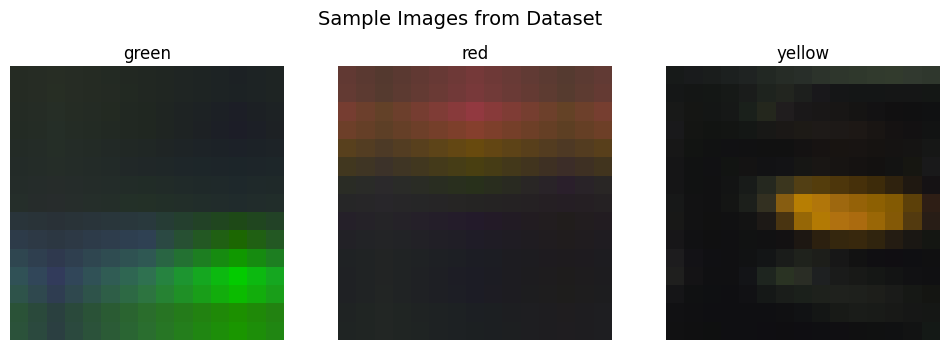

In [9]:
def plot_sample_images(x, y, categories, title="Sample Images from Dataset"):
    fig, axes = plt.subplots(1, len(categories), figsize=(12, 4))
    fig.suptitle(title, fontsize=14)

    for i, category in enumerate(categories):
        idx = np.where(y == category)[0][0]
        img = x[idx].reshape(img_size[0], img_size[1], 3)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(category)
    
    plt.show()


# Show example images from dataset
plot_sample_images(x_train, y_train, categories)


In [10]:
def train_svc(x_train, y_train):
    classifier = SVC(probability=True)
    parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100]}]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Improved cross-validation

    grid_search = GridSearchCV(classifier, parameters, cv=skf, n_jobs=-1, verbose=1)
    grid_search.fit(x_train, y_train)

    logging.info(f"Best Parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [11]:
start_time = time.time()
best_estimator = train_svc(x_train, y_train)
logging.info(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Evaluating Model
y_pred = best_estimator.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
logging.info(f"Validation Accuracy: {accuracy * 100:.2f}%")

#classification report
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025-03-06 13:55:00,931 - INFO - Best Parameters: {'C': 100, 'gamma': 0.01}
2025-03-06 13:55:00,932 - INFO - Training completed in 74.30 seconds.
2025-03-06 13:55:00,974 - INFO - Validation Accuracy: 96.47%


              precision    recall  f1-score   support

       green       0.98      0.94      0.96       200
         red       0.99      0.96      0.98       200
      yellow       0.92      1.00      0.96       166

    accuracy                           0.96       566
   macro avg       0.96      0.97      0.96       566
weighted avg       0.97      0.96      0.96       566



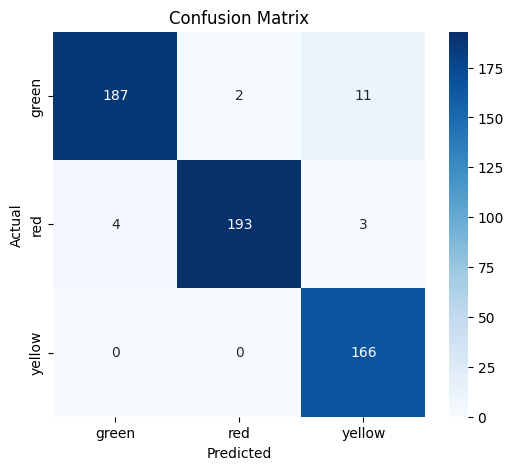

2025-03-06 13:55:01,213 - INFO - Model saved as D:/Capstone/Malicious-Sign-Detection/classifier.pkl
2025-03-06 13:55:02,370 - INFO - Classification Result: green


In [12]:
def plot_confusion_matrix(y_true, y_pred, categories):
    cm = confusion_matrix(y_true, y_pred, labels=categories)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(y_val, y_pred, categories)


### **Save Model**
with open(output_model_path, 'wb') as file:
    pickle.dump(best_estimator, file)

logging.info(f"Model saved as {output_model_path}")



def classify_image_with_unknown(image_path, model, threshold=0.7):
    img = imread(image_path)
    if len(img.shape) == 2:
        img = gray2rgb(img)
    elif img.shape[-1] == 4:
        img = rgba2rgb(img)

    img = resize(img, img_size, anti_aliasing=True).flatten()
    probabilities = model.predict_proba(img.reshape(1, -1))
    max_confidence = np.max(probabilities)
    
    return model.predict(img.reshape(1, -1))[0] if max_confidence >= threshold else "unknown"


#Testing on a single image
test_image_path = "D:/Capstone/Malicious-Sign-Detection/Messenger_creation_9203779869632344.jpg"
result = classify_image_with_unknown(test_image_path, best_estimator, threshold=0.7)
logging.info(f"Classification Result: {result}")
